In [5]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy as sp

In [6]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.5.post2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.4 scipy==1.3.3 pandas==0.25.3 scikit-learn==0.22 statsmodels==0.10.2 python-igraph==0.7.1


In [7]:
results_file = './write/mda.h5ad'

In [8]:
adata = sc.read_10x_mtx('./MDA', var_names = 'gene_symbols', cache=True)

... writing an h5ad cache file to speedup reading next time


In [10]:
barcode_meta = pd.read_csv('./MDA/GBC_barcode_identities.csv', sep=',', index_col=1)

barcode_meta.index = barcode_meta.apply(lambda x:x.name + '-1', axis=1)

print(len(adata.obs.index), len(np.intersect1d(adata.obs.index, barcode_meta.index)))
barcode_meta = barcode_meta.replace({'ACCATCGAAGAACCCGTT':'LM2', 'TGGTAACCGAGGACGACG':'LM2',
                                    'CTAGTCACCGCACTTTTA':'BoM', 'ATCCCGCTACTCCGAACC':'BoM',
                                    'GAGTCAGGCTGGTGATCG':'TGL', 'AGTACGCTGACCACGACA':'TGA',
                                    'CCTGATTTTAGCGTCACC':'Brm2', 'CACAGAACAAATCGACAA':'Brm2'})
barcode_meta

19384 7284


,Unnamed: 0,multiseq barcode
GTGTAACGTTTAGAGA-1,0,BoM
TCAGCCTCAGCGTACC-1,1,BoM
CAAGACTTCGTCTACC-1,2,TGA
GGAAGTGCATACACCA-1,3,LM2
ACACTGATCAATCCGA-1,4,TGA
...,...,...
TCAAGTGGTTACCTGA-1,7279,LM2
GTTTGGAGTGGCACTC-1,7280,BoM
GTGTCCTCATGTGCCG-1,7281,LM2
ACTTCGCCACTGATTG-1,7282,BoM


In [11]:
adata.var_names_make_unique()

In [12]:
adata.obs['multiseq'] = barcode_meta.loc[adata.obs.index, 'multiseq barcode']

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
Trying to set attribute `.obs` of view, making a copy.


normalizing counts per cell
    finished (0:00:01)


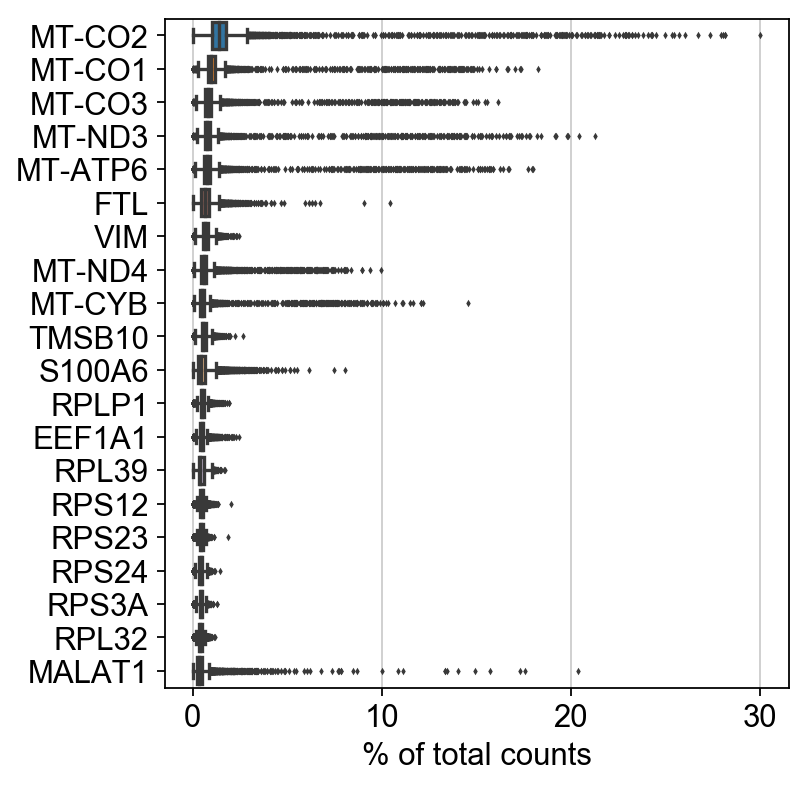

In [13]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [14]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 97 cells that have less than 200 genes expressed
filtered out 12074 genes that are detected in less than 3 cells


In [15]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

... storing 'multiseq' as categorical
... storing 'feature_types' as categorical


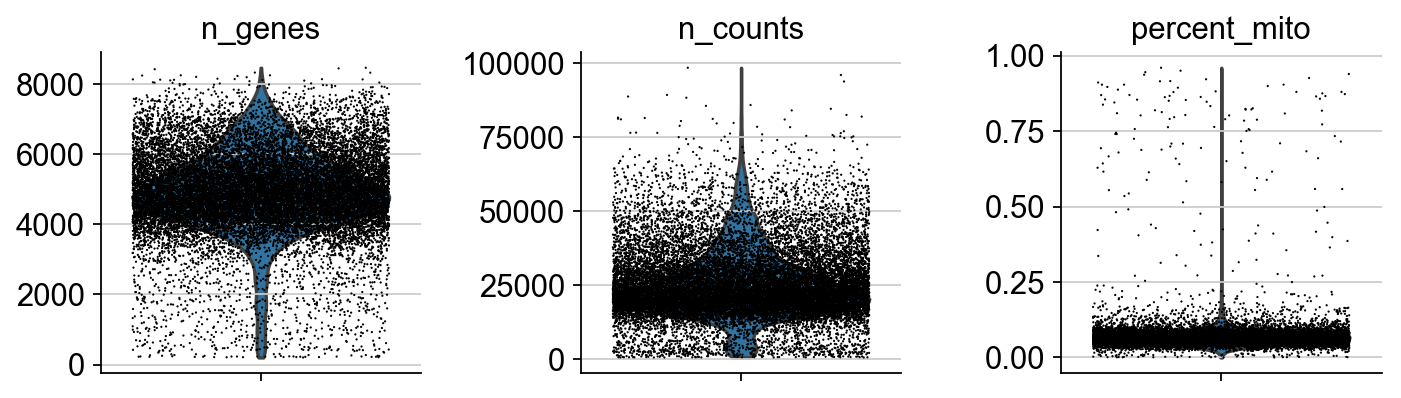

In [16]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)

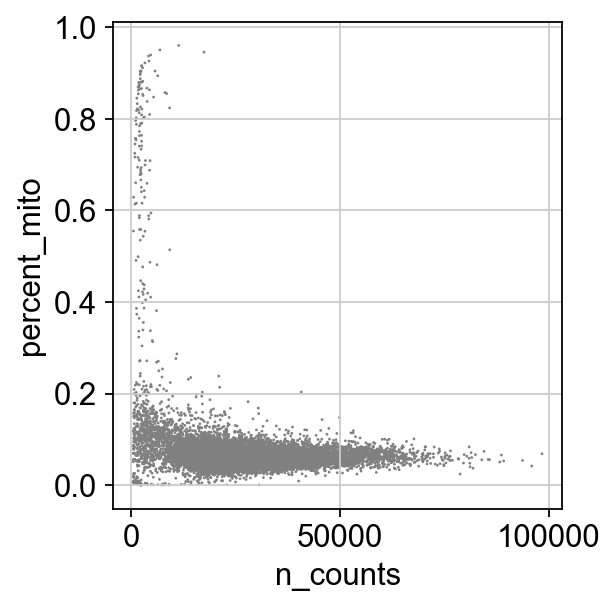

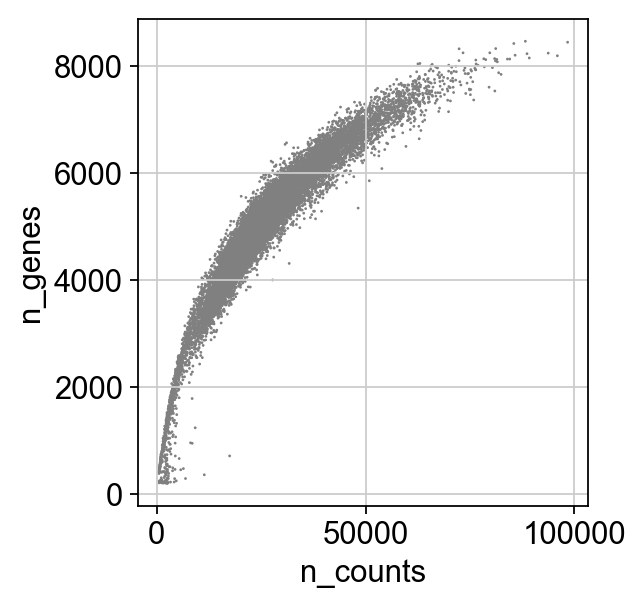

In [17]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [18]:
adata = adata[adata.obs.multiseq != 'nan', :]

In [19]:
adata = adata[adata.obs.n_genes < 8000, :]
adata = adata[adata.obs.percent_mito < 0.2, :]

In [20]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell


Trying to set attribute `.X` of view, making a copy.


    finished (0:00:50)


In [21]:
sc.pp.log1p(adata)

/usr/local/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:298: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


In [22]:
adata.raw = adata


In [23]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [24]:
adata.var[adata.var.highly_variable == True]

,gene_ids,feature_types,n_cells,highly_variable,means,dispersions,dispersions_norm
KLHL17,ENSG00000187961,Gene Expression,1873,True,0.041933,-0.601297,0.575213
HES4,ENSG00000188290,Gene Expression,6849,True,0.185933,-0.483553,1.039964
ISG15,ENSG00000187608,Gene Expression,13796,True,0.516732,-0.288167,1.303956
VWA1,ENSG00000179403,Gene Expression,974,True,0.024177,-0.615843,0.517800
ATAD3B,ENSG00000160072,Gene Expression,7890,True,0.222958,-0.609502,0.542827
...,...,...,...,...,...,...,...
MT-ND1,ENSG00000198888,Gene Expression,19235,True,2.979603,0.988684,1.712652
MT-ATP8,ENSG00000228253,Gene Expression,15823,True,0.661086,-0.338791,1.070758
MT-ND4L,ENSG00000212907,Gene Expression,19042,True,1.474376,0.140743,1.541792
MT-ND5,ENSG00000198786,Gene Expression,19225,True,2.403202,0.966887,1.862189


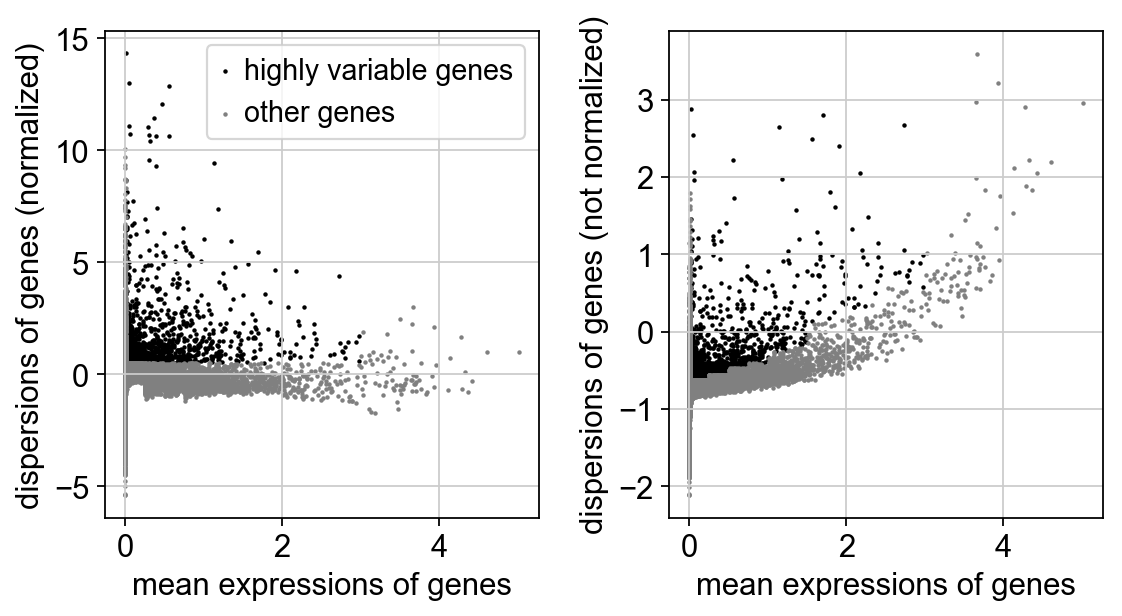

In [25]:
sc.pl.highly_variable_genes(adata)

In [27]:
adata  = adata[:, adata.var.highly_variable]

In [28]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:20)


In [29]:
sc.pp.scale(adata, max_value=10)

In [30]:
import urllib.request
cell_cycle_genes = [x.strip().decode('utf-8') for x in urllib.request.urlopen('https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt')]

In [31]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

In [32]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs) (0:00:01)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs) (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:01)


... storing 'phase' as categorical


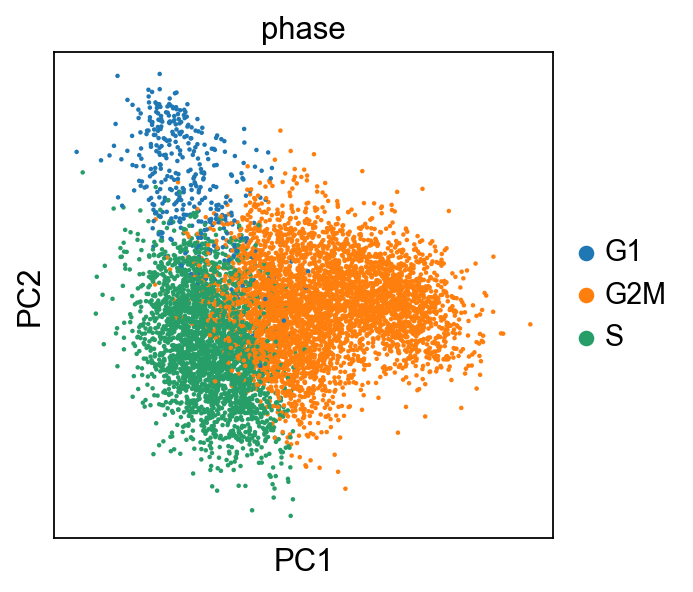

In [33]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

In [34]:
sc.pp.regress_out(adata, ['S_score', 'G2M_score'])

regressing out ['S_score', 'G2M_score']


... storing 'phase' as categorical


    finished (0:00:16)


In [35]:
sc.pp.scale(adata)

computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:01)


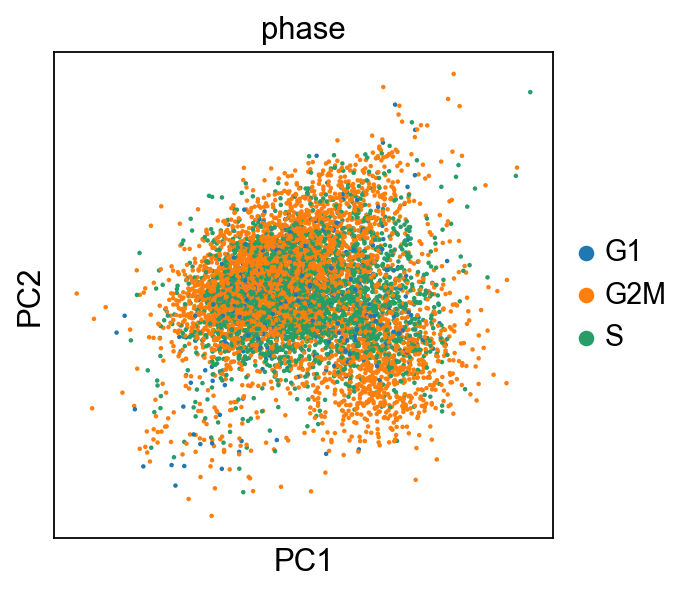

In [36]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

In [37]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:02)


In [38]:
adata

AnnData object with n_obs × n_vars = 7255 × 1670 
    obs: 'multiseq', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

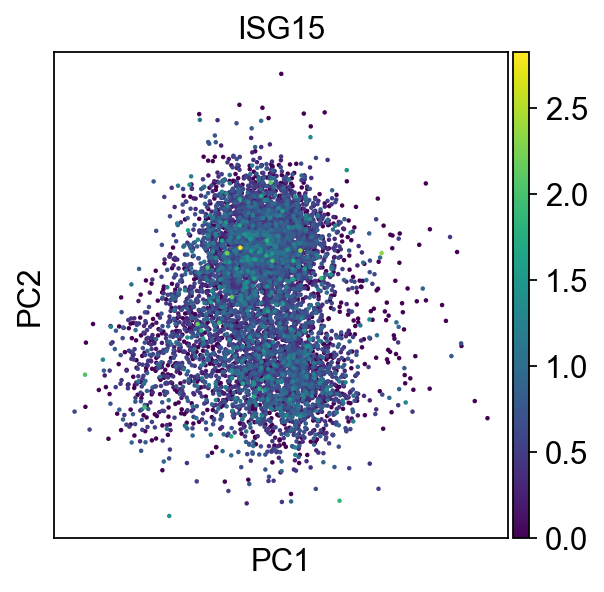

In [40]:
sc.pl.pca(adata, color='ISG15')

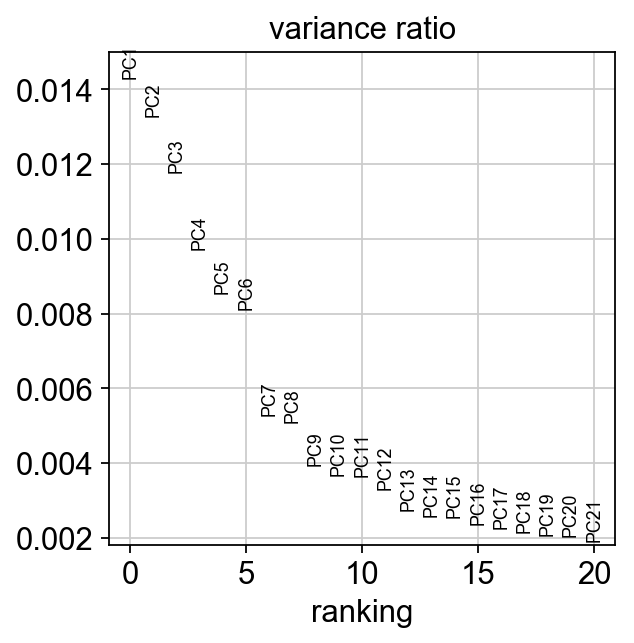

In [41]:
sc.pl.pca_variance_ratio(adata, log=False, n_pcs=20)

In [42]:
adata.write(results_file)

In [44]:
sc.pp.neighbors(adata, n_neighbors=15, knn=True, n_pcs=8)

computing neighbors
    using 'X_pca' with n_pcs = 8
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)


In [45]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


In [105]:
LM2_percent = []
BoM_percent = []
Brm2_percent = []
Parental_percent = []
mask = []
mask_three = []

for i in range(0, len(adata)):
    if adata.obs.iloc[i]['multiseq'] == 'LM2':
        mask.append('LM2')
    elif adata.obs.iloc[i]['multiseq'] == 'BoM':
        mask.append('BoM')
    elif adata.obs.iloc[i]['multiseq'] == 'Brm2':
        mask.append('Brm2')
    else:
        neighbours = adata.obs[adata.uns['neighbors']['distances'].toarray()[i] != 0]
        num_LM2 = len(neighbours[neighbours['multiseq'] == 'LM2'])
        num_BoM = len(neighbours[neighbours['multiseq'] == 'BoM'])
        num_Brm2 = len(neighbours[neighbours['multiseq'] == 'Brm2'])
        if num_LM2/14.0 >= 0.5:
            mask.append('p-LM2')
        elif num_BoM/14.0 >= 0.5:
            mask.append('p-BoM')
        elif num_Brm2/14.0 >= 0.5:
            mask.append('p-Brm2')
        else:
            mask.append('p-Low')




In [107]:
adata.obs['status'] = mask

... storing 'status' as categorical


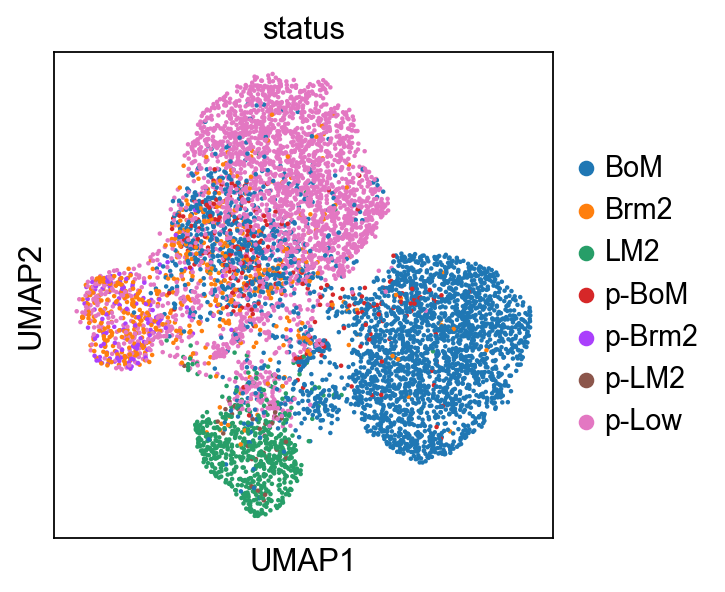

In [108]:
sc.pl.umap(adata, color=['status'])